In [2]:
#|default_exp app

### 1 - Objetivo
O presente trabalho tem o objetivo de testar a evolução na predição de um modelo ao utilizar o `ImageClassifierCleaner` do fastai para remover ou editar as imagens que podem reduzir sua precisão ao identificar ruas asfaltadas ou esburacadas.

### 2 - Esclarecimento
Esse trabalho foi produzido seguindo os ensinamentos do curso  <a href="https://course.fast.ai/">Pratical Deep Learning for Coders</a> - lição 2.

### 3 - Motivação
Visto que o modal majoritariamente utilizado no Brasil é o rodoviário (aproximadamente 60%, segundo a Confederação Nacional de Transportes), este trabalho visa contribuir com a identificação do estado de ruas para facilitar o trabalho de orgãos públicos ou empresas da área no mapeamento da situação brasileira nesse quesito.

Clique aqui para acessar a <a href="https://agenciadenoticias.ibge.gov.br/agencia-sala-de-imprensa/2013-agencia-de-noticias/releases/14707-asi-ibge-mapeia-a-infraestrutura-dos-transportes-no-brasil">referência.</a>

### 4 - Instalação
Para realizar a configuração do ambiente que rodará o projeto é necessário a instalação das seguintes tecnologias:
- <a href="https://www.python.org/download/releases/3.0/">Python3</a>
- <a href="https://code.visualstudio.com/">Visual Studio Code</a>
- <a href="https://pypi.org/project/pip/">Pip</a>

Extensões para o Visual Studio Code
- Jupyter
- Jupyter Keymap
- Jupyter Cell Tags

A seguinte célula faz o import das bibliotecas que serão utilizadas

In [3]:
! pip install -Uqq fastai fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *
from duckduckgo_search import ddg_images
from fastdownload import download_url

### 5 - Criação do Projeto

Para a criação do projeto iremos começar definindo uma função que retornará links de imagens encontradas pela pesquisa de um determinado termo no Duck Duck Go.

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Utilizando a função acima em conjunto com a função "download_images", nesse passo iremos baixar 200 imagens de cada uma das seguintes pesquisas: "rua asfaltada" e "estrada de chão". Essas imagens serão usadas para treinar nosso modelo.

In [5]:
from fastai.vision.all import *
searches = 'rua asfaltada', 'estrada de chão'
path = Path('tipos_rua')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'rua asfaltada'
Searching for 'estrada de chão'


Seguindo o exemplo do <a href="https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data"> Is it a bird? Creating a model from your own data </a> demonstrado no curso, a próxima linha de código irá remover imagens baixadas incorretamente e que não servirão de exemplo para treinar nosso modelo.

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

O conjunto de código seguinte é um DataLoader (objeto que contém as imagens a serem usadas para treinar o modelo). O DataLoader a seguir será criado usando DataBlock.

In [7]:
street_type = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192)
)

In [8]:
dls = street_type.dataloaders(path)

É possível ver parte do lote de imagens tanto do conjunto de treinamento quanto do de validação, como mostrado nas duas células seguintes:

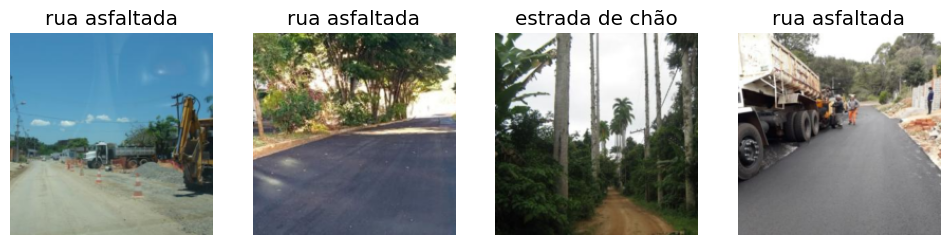

In [9]:
dls.train.show_batch(max_n=4, nrows=1)

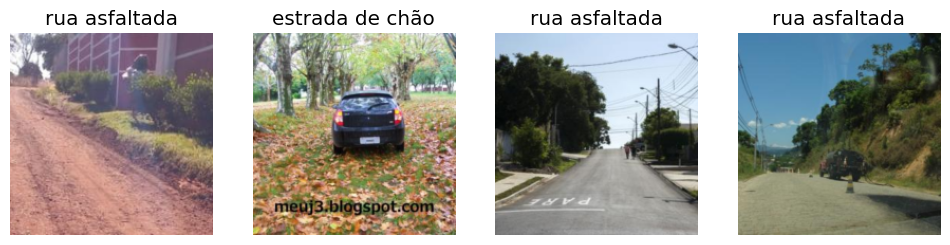

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

Como mostrado na lição 2, o `item_tfms=Resize(192)`, por padrão, corta as imagens - o que não é bom, pois pode-se perder características importantes das imagens. Da mesma forma, o `item_tfms=Resize(128, ResizeMethod.Squish` e o `item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')` deixam a desejar, visto que o primeiro perde as reais características da imagens e o segundo deixa muito espaço vazio.

Uma metodologia eficiente usada para sanar tal problema é o *data augmentarion*, que é a criação de diferentes tipos variações da mesma imagem. Na lição 2 são mostrados duas formas para realizar o *data augmentarion*: `item_tfms=RandomResizedCrop(128, min_scale=0.3)` e `item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2)`.

Utilizaremos no exemplo seguinte o `batch_tfms=aug_transforms(mult=2)` com imagens de 224 pixel, em detrimento da utilização da resnet18.

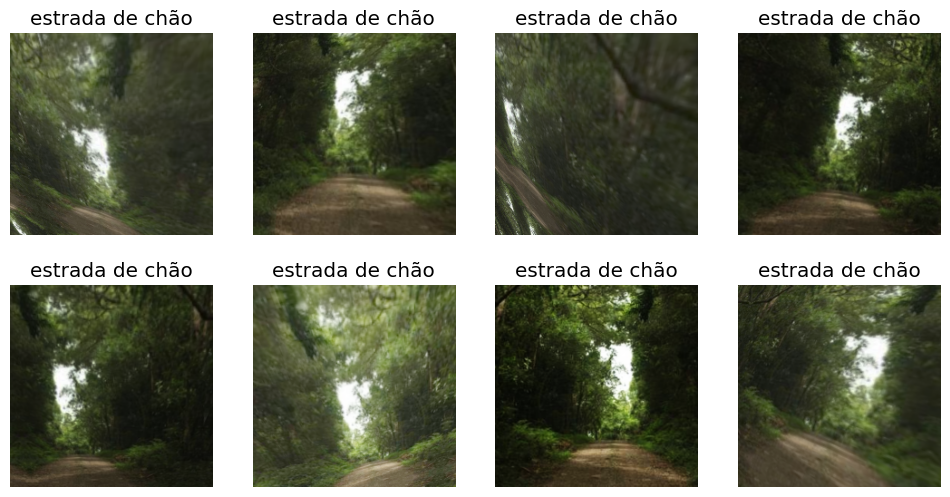

In [11]:
street_type = street_type.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
dls = street_type.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Com tudo pronto, agora iremos treinar o modelo. Para tal, o fastai providencia o "fine_tune", que é um método que usa automaticamente as melhores práticas para o aprimoramento de um modelo pré treinado.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/valdersonjr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/valdersonjr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.573839,0.153428,0.058824,06:35


epoch,train_loss,valid_loss,error_rate,time
0,0.267794,0.086676,0.045752,09:42
1,0.239093,0.101731,0.034858,10:11
2,0.170074,0.073551,0.017429,10:05
3,0.134958,0.061763,0.015251,09:28


A próxima celula tem por função criar uma *matriz de confusão*, onde é possível averiguar a quantidade de erros e acertos do nosso modelo.

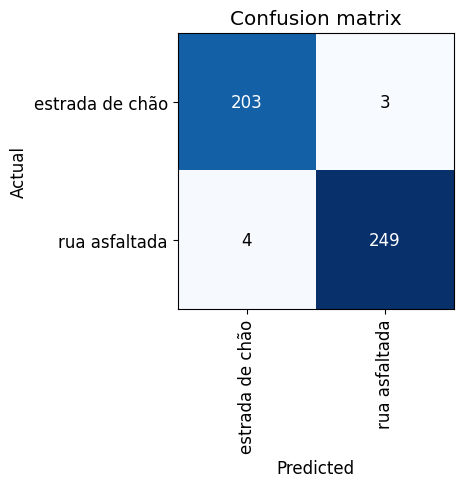

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

O *loss* é um número que define o quão incorreto nosso modelo está sendo (quanto maior mais incorreto), especialmente se estiver muito confiante em uma predição incorreta.

A função `plot_top_losses` é utilizada para retornar as imagens de maiores erros em relação com o *loss*.

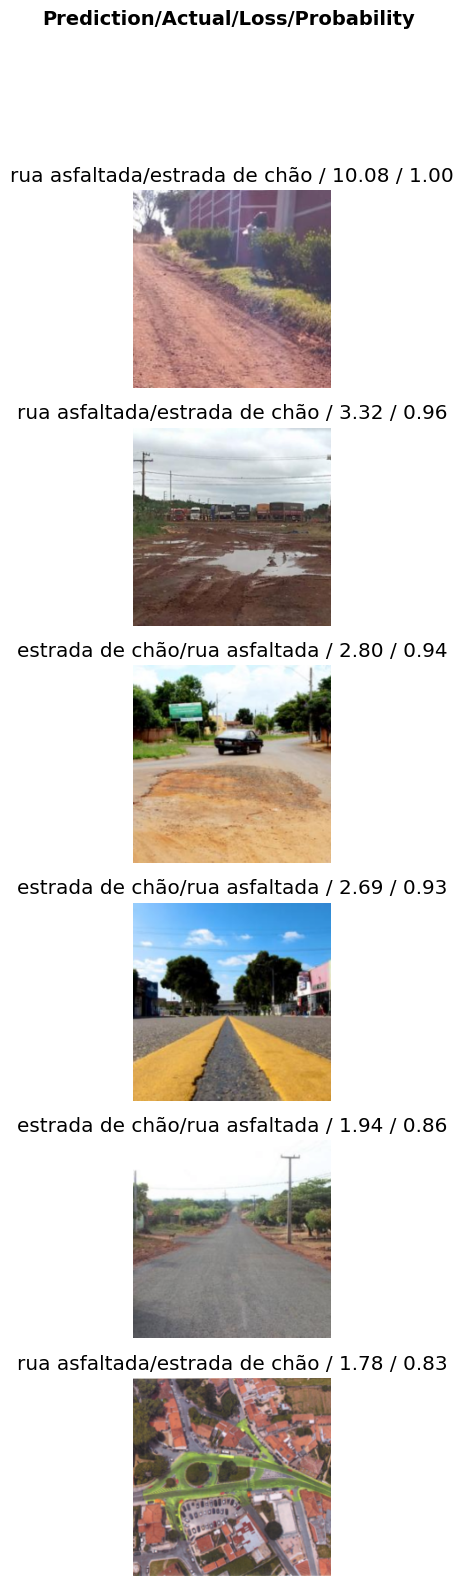

In [14]:
interp.plot_top_losses(6, nrows=6)

O passo seguinte é de extrema importância. Uma das vantagens do fastai é poder utilizar uma interface gráfica para realizar a correção dos dados: `ImageClassifierCleaner`.

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Tendo ajustado as predições que continham erro, treinaremos novamente nosso modelo para comparar o nível de erro com a primeira tentativa de treinamento realizada anteriormente.

In [17]:
dls = street_type.dataloaders(path)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.659236,0.287755,0.094092,04:01


epoch,train_loss,valid_loss,error_rate,time
0,0.277980,0.157165,0.054705,06:06
1,0.227908,0.145687,0.035011,06:05
2,0.188429,0.102389,0.028446,06:06
3,0.152687,0.085442,0.021882,06:23


Para saber a probabilidade vamos usar a função `predict`, que retorna a predição, o index da predição e as probabilidades de cada categoria.
*Lembrando que as categorias são consideradas em ordem alfabética.*

In [19]:
learn.dls.vocab

['estrada de chão', 'rua asfaltada']

In [20]:
learn.predict('asfaltada.jpg')

('rua asfaltada', TensorBase(1), TensorBase([1.8137e-07, 1.0000e+00]))

### 6 - Realizando o deploy

As próximas etapas condizem com a realização do *deploy* do nosso modelo. Para tal, visto que um modelo consistem em duas partes (arquitetura e parâmetros treinados), para salva-lo basta salvar essas partes.


Para salvar nosso modelo basta utilizar a função `export` e o fastai irá criar um arquivo chamado "export.pkl" com todas as informações necessárias.

In [21]:
learn.export('export.pkl')

Vale ainda notar que as linhas de códigos destinadas ao deploy estão demarcadas com `#|export` no início de cada célula, pois iremos utilizar uma biblioteca que cria o `app.py` automaticamente.

Realizando os imports necessários para a aplicação:

In [22]:
#|export
import gradio as gr
from fastai.vision.all import *

In [23]:
#|export
learn_deploy = load_learner('export.pkl')

Criando a função que será utilizada para classificar as imagens em produção.

In [24]:
#|export
categories = ('estrada de chão', 'rua asfaltada')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

Baixando as imagens para usar de exemplo:

Searching for 'rua asfaltada'


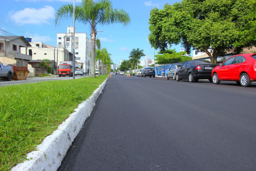

In [25]:
download_url(search_images('rua asfaltada', max_images=1)[0], 'asfaltada.jpg', show_progress=False)
Image.open('asfaltada.jpg').to_thumb(256,256)

Searching for 'estrada de chão'


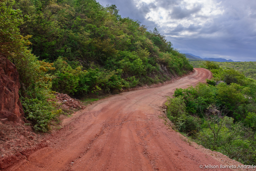

In [26]:
download_url(search_images('estrada de chão', max_images=1)[0], 'estrada.jpg', show_progress=False)
Image.open('estrada.jpg').to_thumb(256,256)

O bloco de código seguinte condiz com a criação da interface gráfica que será enviada para o `huggingface`.

Pode-se notar que ela utiliza a função `classify_image` criada anteriormente (onde está sendo utilizado o modelo importado) para realizar as predições.

Vale ainda ressaltar que a aplicação terá como entrada uma uma imagem `inputs=image`, como saída um rótulo `outputs=label` e, por fim, duas imagens de exemplo `examples=examples` (onde a variável examples é um array com path das imagens).

*Obs: para rodar localmente o projeto utiliza-se a linha de código `intf.launch(inline=False)`*.

In [27]:
#|export
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['asfaltada.jpg', 'estrada.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/home/valdersonjr/.local/lib/python3.8/site-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/home/valdersonjr/.local/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/valdersonjr/.local/lib/python3.8/site-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/valdersonjr/.local/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7eff1006adc0>, 'http://127.0.0.1:7860/', None)

Para realizar a criação automática do arquivo `app.py` iremos instalar a biblioteca `nbdev`:

In [28]:
pip install nbdev

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Ainda para a criaçao automática do `app.py`, vamos importar para nosso projeto o `export` para utilizar a função `nb_export`, que é a função que realiza a criação.

In [36]:
from nbdev import export

In [38]:
export.nb_export('02_tipos_rua.ipynb')

Por fim, para realizar o deploy da sua aplicação é necessário apenas criar um *space* no `huggingface` e realizar o commit do conjunto de arquivo gerado.

<b>IMPORTANTE!</b>
> Caso não esteja conseguindo realizar o push em detrimento do site não aceitar arquivo binário (o ".pkl"), basta commitar e dar push no `.gitattributes` antes de commitar e dar o push do restante dos arquivos.

Discutido nesse fórum pelo Zakia: <a href="https://forums.fast.ai/t/lesson-1-official-topic/95287/188">clique aqui</a>.